[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/talmolab/dreem/blob/docs/examples/microscopy-demo-simple.ipynb)

## DREEM workflow for microscopy
### From raw tiff stacks to tracked identities

This notebook will walk you through the typical workflow for microscopy identity tracking. We start with a raw tiff stack, pass it through an off-the-shelf detection model, and feed those detections into DREEM. 

This notebook uses a simple entrypoint into the tracking code. You only need to specify a configuration file, and a few lines of code!

To run this demo, we have provided sample data and model checkpoints. A GPU is recommended if you run the CellPose segmentation step, otherwise the tracking will run on a CPU.

#### Install DREEM and dependencies (Colab only)


In [ ]:
# Install uv (fast Python package installer)
%pip install uv

# Install dreem and dependencies using uv
!uv pip install dreem-track huggingface_hub tifffile opencv-python-headless

# Install ffmpeg for video export (Colab-specific)
!apt-get install -y ffmpeg

#### Import necessary packages

In [1]:
import os
import torch
import numpy as np
import tifffile
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
from huggingface_hub import hf_hub_download
import subprocess

/Users/main/dreem-docs/dreem/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Download a pretrained model, configs and some data

In [2]:
model_save_dir = "./models"
config_save_dir = "./configs"
os.makedirs(config_save_dir, exist_ok=True)
os.makedirs(model_save_dir, exist_ok=True)

In [3]:
model_path = hf_hub_download(
    repo_id="talmolab/microscopy-pretrained",
    filename="pretrained-microscopy.ckpt",
    local_dir=model_save_dir,
)

config_path = hf_hub_download(
    repo_id="talmolab/microscopy-pretrained",
    filename="sample-microscopy-config.yaml",
    local_dir=config_save_dir,
)

In [4]:
!hf download talmolab/microscopy-demo --repo-type dataset --local-dir ./data

Fetching 646 files: 100%|█████████████████████| 646/646 [00:26<00:00, 24.46it/s]
Download complete: : 79.0MB [00:26, 3.42MB/s]                                   /Users/main/dreem-docs/dreem/examples/data
Download complete: : 79.0MB [00:26, 2.99MB/s]


Check if a GPU is available. For Apple silicon users, you can run on MPS, but ensure your version of PyTorch is compatible with MPS, and that you have installed the correct version of DREEM. You can also run without a GPU. The demo has been tested on an M3 Macbook Air running only on a CPU.


In [7]:
cuda_available = torch.cuda.is_available()
print(f"CUDA available: {cuda_available}")
if cuda_available:
    accelerator = "cuda"
elif torch.backends.mps.is_available():
    accelerator = "mps"
    devices = 1
else:
    accelerator = "cpu"
print("Using device: ", accelerator)

torch.set_float32_matmul_precision("medium")

CUDA available: False
Using device:  mps


## Detection

Here we use CellPose to create segmentation masks for our instances. **If you want to skip this stage**, we have provided segmentation masks for the lysosomes dataset located at ./data/lysosomes, and you can go straight ahead to the "Tracking" section below

#### Run CellPose segmentation with uv

In [5]:
data_path = "./data/dynamicnuclearnet/test_1"
segmented_path = "./data/dynamicnuclearnet/test_1_GT/TRA"
os.makedirs(segmented_path, exist_ok=True)

Set the approximate diameter (in pixels) of the instances you want to segment

In [6]:
diam_px = 25

#### Run detection model

In [ ]:
gpu_flag = "--gpu" if torch.cuda.is_available() else "--no-gpu"

print("Running CellPose segmentation with uv...")
result = subprocess.run(
    [
        "uv",
        "run",
        "run_cellpose_segmentation.py",
        "--data_path",
        data_path,
        "--output_path",
        segmented_path,
        "--diameter",
        str(diam_px),
        gpu_flag,
    ],
    check=True,
    capture_output=True,
    text=True,
)
print(result.stdout)
if result.stderr:
    print("Errors/Warnings:", result.stderr)

# Load the original stack and masks for visualization
tiff_files = [
    f for f in os.listdir(data_path) if f.endswith(".tif") or f.endswith(".tiff")
]
tiff_files.sort()  # Ensure consistent ordering
first_img = tifffile.imread(os.path.join(data_path, tiff_files[0]))
mask_path = os.path.join(segmented_path, f"{os.path.splitext(tiff_files[0])[0]}.tif")
first_mask = tifffile.imread(mask_path)

### View the segmentation result and original image 

NameError: name 'first_mask' is not defined

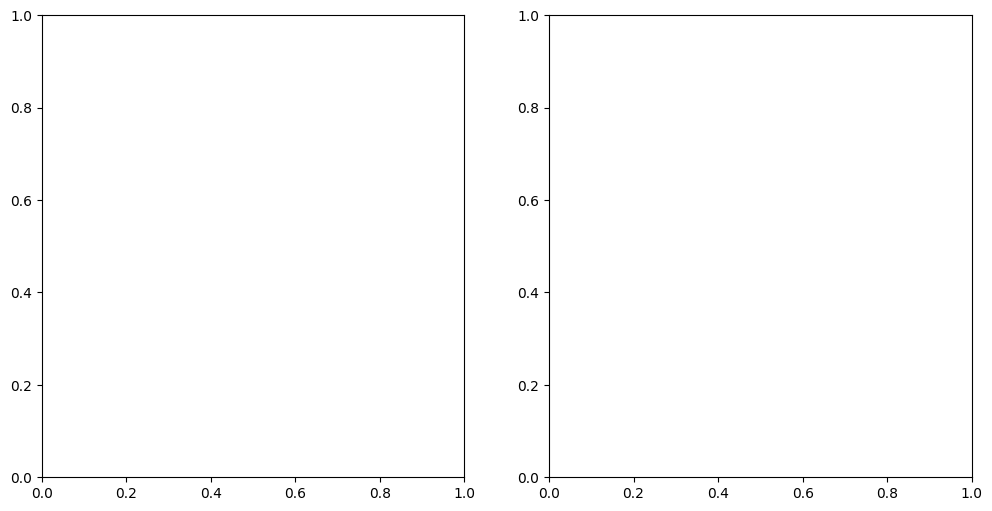

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(first_mask)
ax1.set_title("Segmentation Mask")
ax2.imshow(first_img)
ax2.set_title("Original Image")
plt.tight_layout()
plt.show()

## Tracking
Note that the segmented masks are saved to ./data/dynamicnuclearnet/test_1_GT/TRA; in general, any segmented masks are expected to be in a directory with the same name as the original data, with _GT/TRA appended to the end.

The command below assumes you have run the CellPose segmentation step, and that the segmented masks are saved to ./data/dynamicnuclearnet/test_1_GT/TRA. If you have not run the segmentation step, you can use the following command to track the lysosome data that we have provided: 

```
!dreem track ./data/lysosomes --checkpoint ./models/pretrained-microscopy.ckpt --output ./results-lyso --video-type tif --crop-size 22
```


In [ ]:
!dreem track ./data/dynamicnuclearnet --checkpoint ./models/pretrained-microscopy.ckpt --output ./results-dnn --video-type tif --crop-size 32

Configuration saved to: results-lyso/config.track.02-04-2026-14-40-21.yaml
╭──────────────────────────── Track Configuration ─────────────────────────────╮
│ Checkpoint:  models/pretrained-microscopy.ckpt                               │
│ Output:      results-lyso                                                    │
│ Input:       data/lysosomes                                                  │
╰──────────────────────────────────────────────────────────────────────────────╯
Predicting ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 0:00:50 • 0:00:00 0.16it/s 0.13it/s 
Results saved to results-lyso


### Visualize the results
To visualize the tracked tiff stacks, you can use tools like ImageJ, Fiji, or Napari plugins.